# Skripsi : Deteksi Kerusakan Jalan Aspal Menggunakan Algoritma YOLOv9

**Keterangan :** \
image size : 512 fit in no augmentation\
epoch : 150 \
batch : 16 \
hyp : default \
Data : 80:10:10 \
lr : 0.0001

# GPU Check

In [ ]:
!nvidia-smi

Fri Sep 20 02:11:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Install YOLOv9

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!git clone https://github.com/WongKinYiu/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 781, done.
remote: Total 781 (delta 0), reused 0 (delta 0), pack-reused 781 (from 1)
Receiving objects: 100% (781/781), 3.27 MiB | 7.73 MiB/s, done.
Resolving deltas: 100% (331/331), done.
/content/yolov9
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.4 MB/s eta 0:00:00


# Download Model Weights

In [ ]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [ ]:
!ls -la {HOME}/weights

total 402444
drwxr-xr-x 2 root root      4096 Sep 20 02:11 .
drwxr-xr-x 1 root root      4096 Sep 20 02:11 ..
-rw-r--r-- 1 root root  51508261 Feb 18  2024 gelan-c.pt
-rw-r--r-- 1 root root 117203713 Feb 18  2024 gelan-e.pt
-rw-r--r-- 1 root root 103153312 Feb 18  2024 yolov9-c.pt
-rw-r--r-- 1 root root 140217688 Feb 18  2024 yolov9-e.pt


# Install Roboflow

In [ ]:
!pip install -q roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.5 MB/s eta 0:00:00


# Download Data

Dataset disimpan dalam folder {HOME}/yolov9 agar bisa dilakukan proses pelatihan

In [ ]:
%cd {HOME}/yolov9

/content/yolov9


In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="mKfBaoS5ZsLfPjDXBp1i")
project = rf.workspace("muhammadfarkhan").project("deteksi-kerusakan-jalan-qndim")
version = project.version(23)
dataset = version.download("yolov9")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Deteksi-Kerusakan-Jalan-23 in yolov9:: 100%|██████████| 6654/6654 [00:03<00:00, 1926.79it/s]


## Distribusi Dataset
Dataset dibagi menjadi 80% data training, 10% data validation, dan 10% data testing. Total 3321 dataset gambar.

In [ ]:
import os
from collections import Counter
import matplotlib.pyplot as plt
from collections import Counter

**Distribusi Data Training**

{'alligator_cracking': 773, 'lateral_cracking': 926, 'longitudinal_cracking': 1766, 'pothole': 2105}


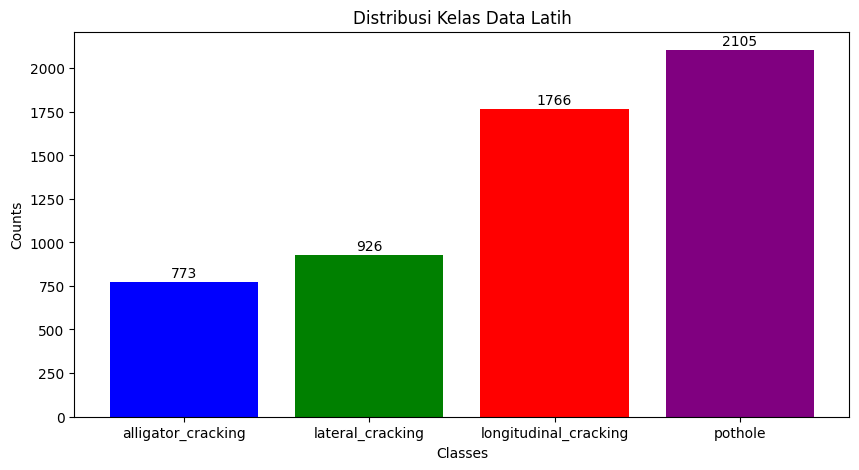

In [ ]:
annotations_path = os.path.join(dataset.location, 'train/labels')

class_names = {
    0: "alligator_cracking",
    1: "lateral_cracking",
    2: "longitudinal_cracking",
    3: "pothole"
}

class_counter = Counter()
for filename in os.listdir(annotations_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(annotations_path, filename)
        with open(file_path, 'r') as file:
            for line in file:
                class_id = int(line.split()[0])
                class_counter[class_id] += 1

# Mapping hasil ke nama kelas dan mengurutkannya
sorted_class_counts = {class_names[k]: class_counter[k] for k in sorted(class_names)}
print(sorted_class_counts)

# Membuat grafik
labels = list(sorted_class_counts.keys())
counts = list(sorted_class_counts.values())

plt.figure(figsize=(10, 5))
bars = plt.bar(labels, counts, color=['blue', 'green', 'red', 'purple'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, int(yval), ha='center', va='bottom')

plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Distribusi Kelas Data Latih')
plt.show()

**Distribusi Data Validasi**

{'alligator_cracking': 79, 'lateral_cracking': 126, 'longitudinal_cracking': 223, 'pothole': 284}


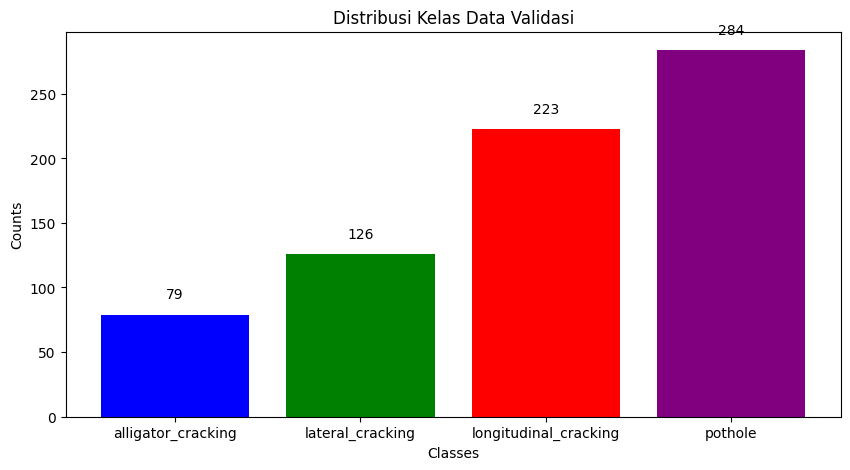

In [ ]:
annotations_path = os.path.join(dataset.location, 'valid/labels')

class_names = {
    0: "alligator_cracking",
    1: "lateral_cracking",
    2: "longitudinal_cracking",
    3: "pothole"
}

class_counter = Counter()
for filename in os.listdir(annotations_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(annotations_path, filename)
        with open(file_path, 'r') as file:
            for line in file:
                class_id = int(line.split()[0])
                class_counter[class_id] += 1

# Mapping hasil ke nama kelas dan mengurutkannya
sorted_class_counts = {class_names[k]: class_counter[k] for k in sorted(class_names)}
print(sorted_class_counts)

# Membuat grafik
labels = list(sorted_class_counts.keys())
counts = list(sorted_class_counts.values())

plt.figure(figsize=(10, 5))
bars = plt.bar(labels, counts, color=['blue', 'green', 'red', 'purple'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, int(yval), ha='center', va='bottom')

plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Distribusi Kelas Data Validasi')
plt.show()


**Distribusi** Data Testing

{'alligator_cracking': 103, 'lateral_cracking': 121, 'longitudinal_cracking': 233, 'pothole': 266}


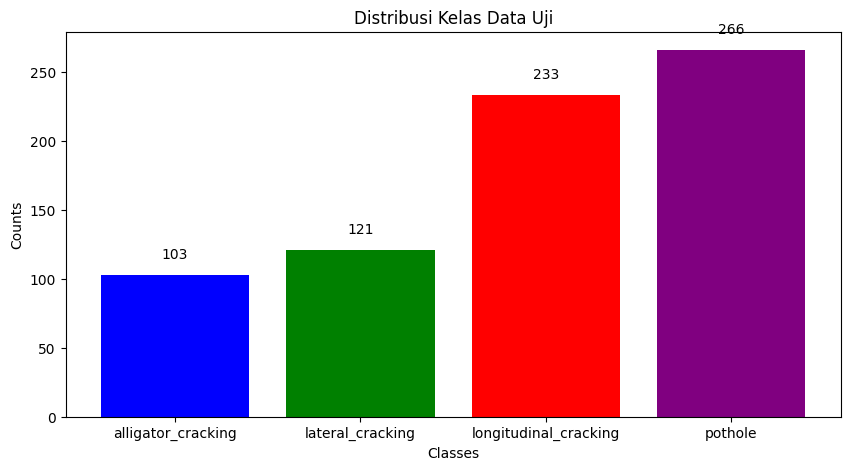

In [ ]:
annotations_path = os.path.join(dataset.location, 'test/labels')

class_names = {
    0: "alligator_cracking",
    1: "lateral_cracking",
    2: "longitudinal_cracking",
    3: "pothole"
}

class_counter = Counter()
for filename in os.listdir(annotations_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(annotations_path, filename)
        with open(file_path, 'r') as file:
            for line in file:
                class_id = int(line.split()[0])
                class_counter[class_id] += 1

# Mapping hasil ke nama kelas dan mengurutkannya
sorted_class_counts = {class_names[k]: class_counter[k] for k in sorted(class_names)}
print(sorted_class_counts)

# Membuat grafik
labels = list(sorted_class_counts.keys())
counts = list(sorted_class_counts.values())

plt.figure(figsize=(10, 5))
bars = plt.bar(labels, counts, color=['blue', 'green', 'red', 'purple'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, int(yval), ha='center', va='bottom')

plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Distribusi Kelas Data Uji')
plt.show()


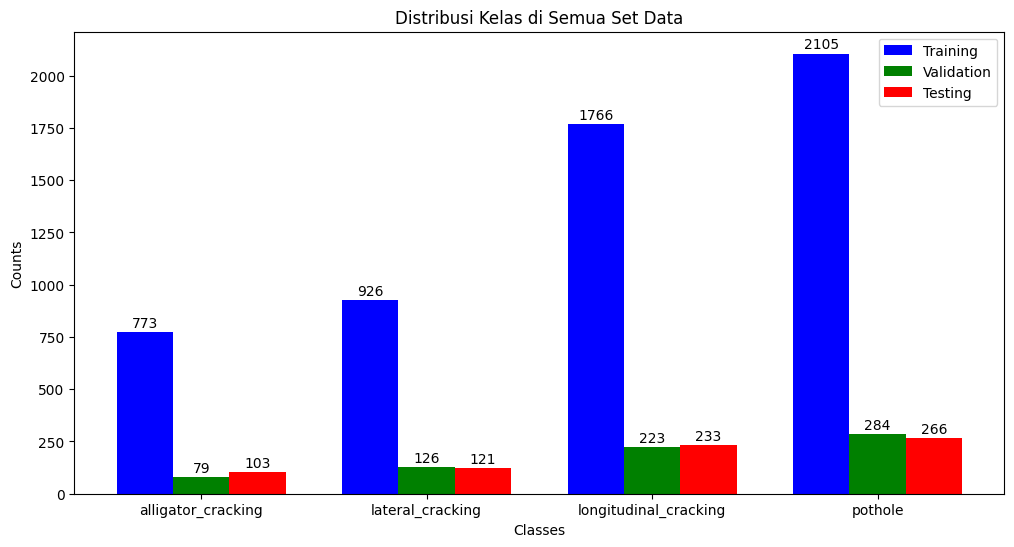

In [ ]:
# prompt: gabungkan ketiga grafik diatas menjadi satu skala yang sama, dimulai dari data training, validation, dan testing

import os
from collections import Counter
import matplotlib.pyplot as plt

# Path ke folder anotasi untuk setiap set data
train_annotations_path = os.path.join(dataset.location, 'train/labels')
valid_annotations_path = os.path.join(dataset.location, 'valid/labels')
test_annotations_path = os.path.join(dataset.location, 'test/labels')

# Nama kelas
class_names = {
    0: "alligator_cracking",
    1: "lateral_cracking",
    2: "longitudinal_cracking",
    3: "pothole"
}

# Menghitung jumlah setiap kelas di setiap set data
train_class_counter = Counter()
for filename in os.listdir(train_annotations_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(train_annotations_path, filename)
        with open(file_path, 'r') as file:
            for line in file:
                class_id = int(line.split()[0])
                train_class_counter[class_id] += 1

valid_class_counter = Counter()
for filename in os.listdir(valid_annotations_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(valid_annotations_path, filename)
        with open(file_path, 'r') as file:
            for line in file:
                class_id = int(line.split()[0])
                valid_class_counter[class_id] += 1

test_class_counter = Counter()
for filename in os.listdir(test_annotations_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(test_annotations_path, filename)
        with open(file_path, 'r') as file:
            for line in file:
                class_id = int(line.split()[0])
                test_class_counter[class_id] += 1

# Mengurutkan hasil berdasarkan nama kelas
sorted_train_class_counts = {class_names[k]: train_class_counter[k] for k in sorted(class_names)}
sorted_valid_class_counts = {class_names[k]: valid_class_counter[k] for k in sorted(class_names)}
sorted_test_class_counts = {class_names[k]: test_class_counter[k] for k in sorted(class_names)}

# Membuat grafik gabungan
labels = list(sorted_train_class_counts.keys())
train_counts = list(sorted_train_class_counts.values())
valid_counts = list(sorted_valid_class_counts.values())
test_counts = list(sorted_test_class_counts.values())

x = range(len(labels))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x, train_counts, width=width, label='Training', color='blue')
plt.bar([i + width for i in x], valid_counts, width=width, label='Validation', color='green')
plt.bar([i + 2 * width for i in x], test_counts, width=width, label='Testing', color='red')

for i, (train_count, valid_count, test_count) in enumerate(zip(train_counts, valid_counts, test_counts)):
    plt.text(i, train_count + 10, int(train_count), ha='center', va='bottom')
    plt.text(i + width, valid_count + 10, int(valid_count), ha='center', va='bottom')
    plt.text(i + 2 * width, test_count + 10, int(test_count), ha='center', va='bottom')

plt.xticks([i + width for i in x], labels)
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Distribusi Kelas di Semua Set Data')
plt.legend()
plt.show()


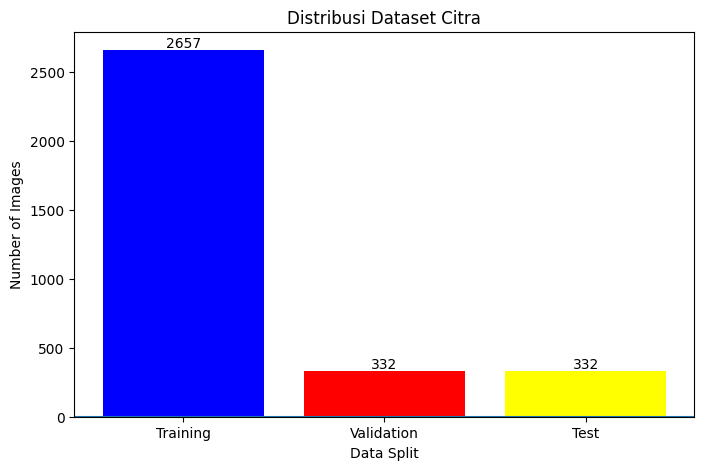

In [ ]:
import os
import matplotlib.pyplot as plt

train_dir = os.path.join(dataset.location, 'train/labels')
val_dir = os.path.join(dataset.location, 'valid/labels')
test_dir = os.path.join(dataset.location, 'test/labels')


train_count = len(os.listdir(train_dir))
val_count = len(os.listdir(val_dir))
test_count = len(os.listdir(test_dir))

labels = ['Training', 'Validation', 'Test']
counts = [train_count, val_count, test_count]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts, color=['blue', 'red', 'yellow'])
plt.xlabel('Data Split')
plt.ylabel('Number of Images')
plt.title('Distribusi Dataset Citra')
plt.axhline()
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')
plt.show()

# Data Training

In [ ]:
%cd {HOME}/yolov9

!python train.py \
--batch 16 --epochs 150 --img 512 --device 0 --min-items 0 --close-mosaic 15\
--data {dataset.location}/data.yaml \
--weights {HOME}/weights/gelan-c.pt \
--cfg models/detect/gelan-c.yaml \
--hyp hyp.scratch-high.yaml

/content/yolov9
2024-09-20 02:13:09.076216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-20 02:13:09.110767: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-20 02:13:09.120927: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-20 02:13:09.143209: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-20 02:13:10.705948: W tensorf

# Training Result

In [ ]:
!unzip /content/drive/MyDrive/results_yolov9/fix_skripsi_yolov9-c_640__default_150.zip -d /content/yolov9

Archive:  /content/drive/MyDrive/results_yolov9/fix_skripsi_yolov9-c_640__default_150.zip
   creating: /content/yolov9/train/
   creating: /content/yolov9/train/exp/
  inflating: /content/yolov9/train/exp/val_batch2_labels.jpg  
  inflating: /content/yolov9/train/exp/val_batch0_labels.jpg  
  inflating: /content/yolov9/train/exp/train_batch2.jpg  
  inflating: /content/yolov9/train/exp/val_batch0_pred.jpg  
  inflating: /content/yolov9/train/exp/labels.jpg  
  inflating: /content/yolov9/train/exp/val_batch1_pred.jpg  
  inflating: /content/yolov9/train/exp/P_curve.png  
  inflating: /content/yolov9/train/exp/val_batch2_pred.jpg  
  inflating: /content/yolov9/train/exp/events.out.tfevents.1723116043.6d344e899063.1036.0  
  inflating: /content/yolov9/train/exp/labels_correlogram.jpg  
  inflating: /content/yolov9/train/exp/F1_curve.png  
  inflating: /content/yolov9/train/exp/hyp.yaml  
  inflating: /content/yolov9/train/exp/PR_curve.png  
  inflating: /content/yolov9/train/exp/train_bat

In [ ]:
!ls {HOME}/yolov9/runs/train/exp/

confusion_matrix.png				    PR_curve.png	   val_batch0_pred.jpg
events.out.tfevents.1723116043.6d344e899063.1036.0  R_curve.png		   val_batch1_labels.jpg
F1_curve.png					    results.csv		   val_batch1_pred.jpg
hyp.yaml					    results.png		   val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch0.jpg	   val_batch2_pred.jpg
labels.jpg					    train_batch1.jpg	   weights
opt.yaml					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


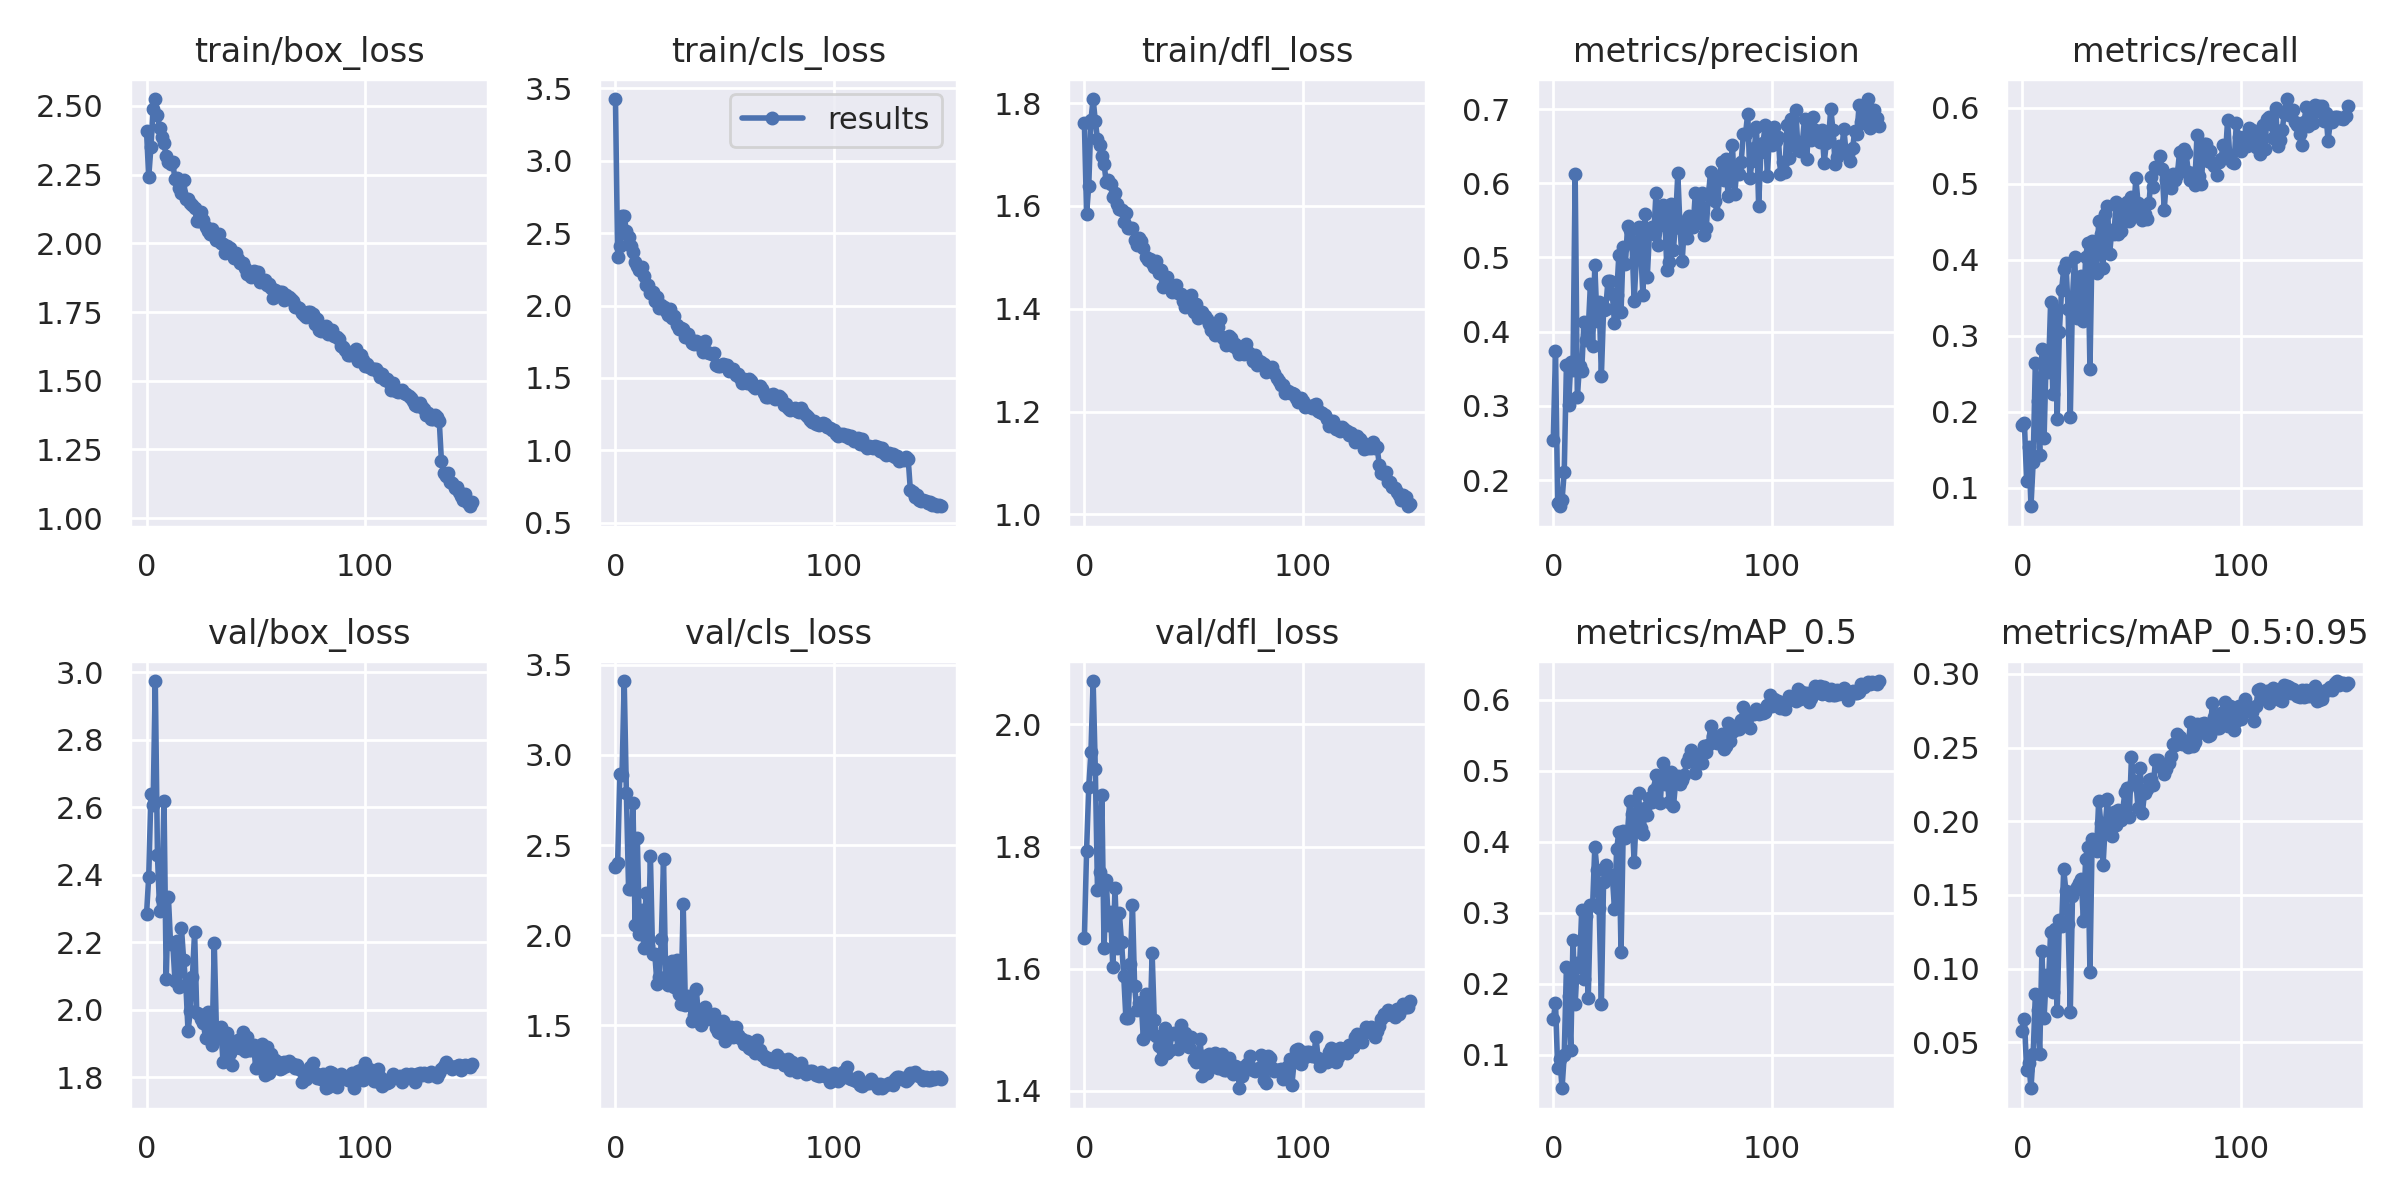

In [ ]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/results.png", width=1000)

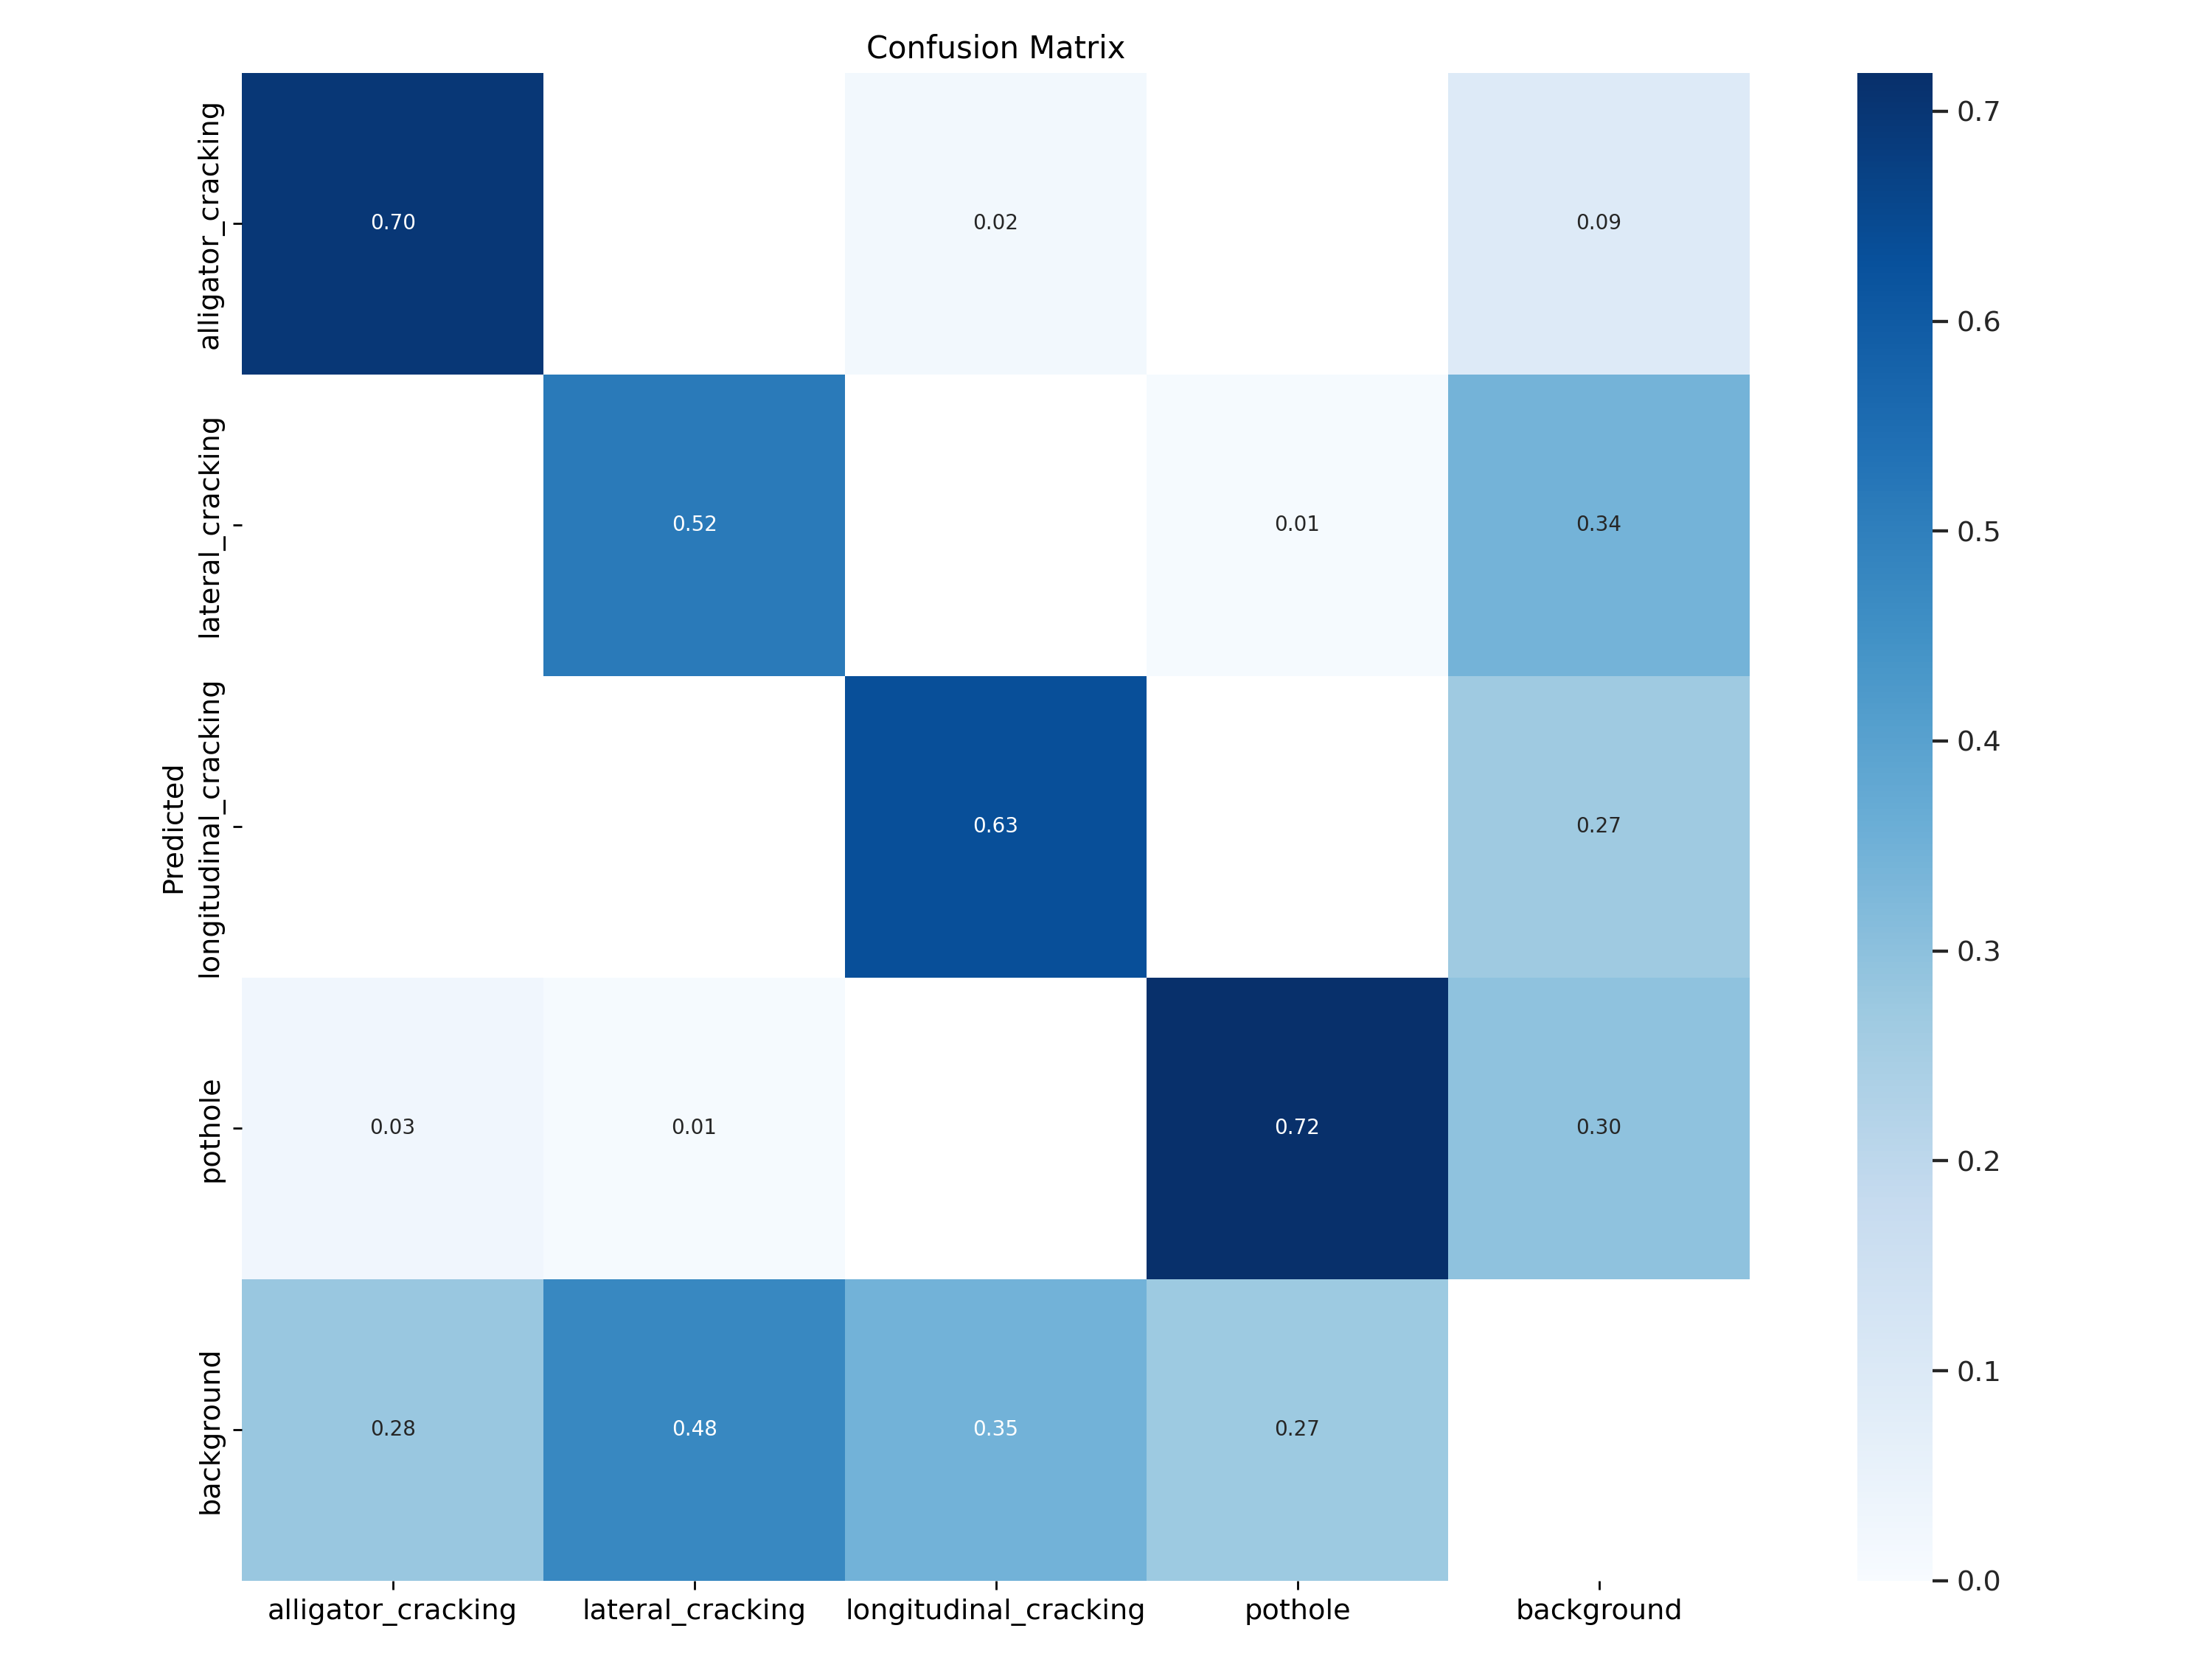

In [ ]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/confusion_matrix.png", width=1000)

## Precision

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

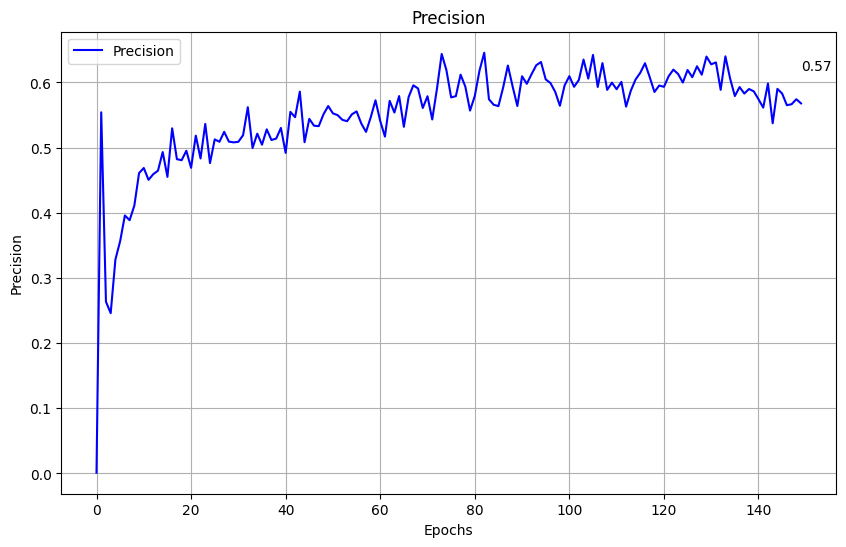

In [ ]:
# Baca data dari file CSV
csv_path = '/content/yolov9/runs/train/exp/results.csv'
data = pd.read_csv(csv_path)

# Ekstrak kolom precision
# Asumsikan bahwa kolom precision berada di indeks ke-4 (karena indeks mulai dari 0)
precision = data.iloc[:, 4]

# Buat grafik line chart
plt.figure(figsize=(10, 6))
plt.plot(precision, label='Precision', color='blue')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
last_value = precision.iloc[-1]
plt.annotate(f'{last_value:.2f}',
             xy=(len(precision)-1, last_value),
             xytext=(len(precision)-1, last_value + 0.05))
plt.show()

## Recall

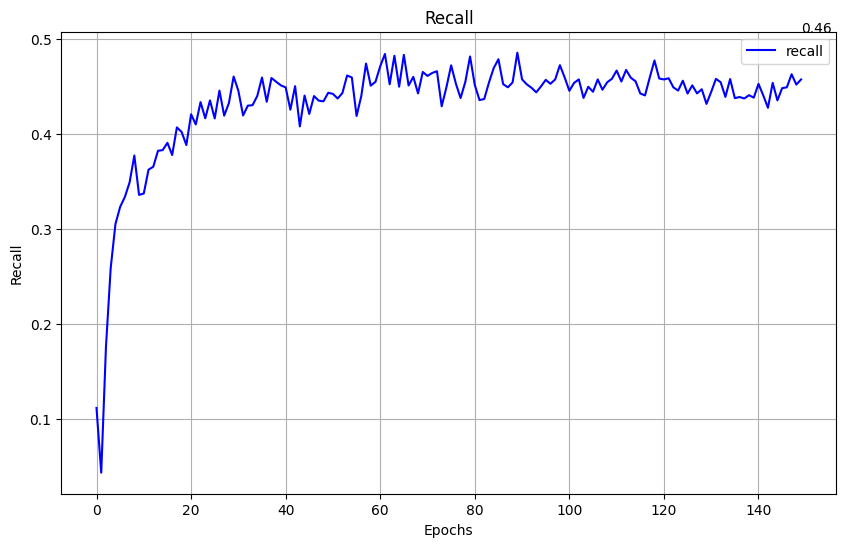

In [ ]:
recall = data.iloc[:, 5]

# Buat grafik line chart
plt.figure(figsize=(10, 6))
plt.plot(recall, label='recall', color='blue')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
last_value = recall.iloc[-1]
plt.annotate(f'{last_value:.2f}',
             xy=(len(recall)-1, last_value),
             xytext=(len(recall)-1, last_value + 0.05))
plt.show()

## mAP (mean Average Precision)

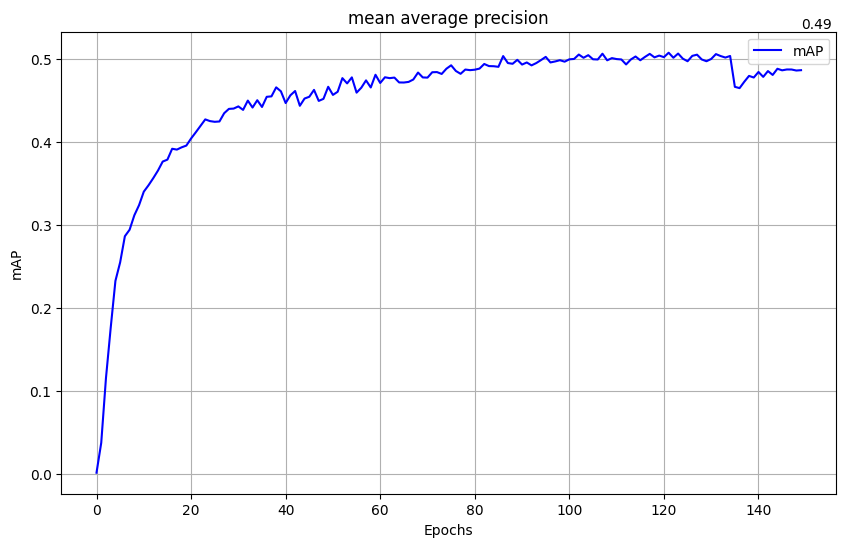

In [ ]:
mAP = data.iloc[:, 6]

# Buat grafik line chart
plt.figure(figsize=(10, 6))
plt.plot(mAP, label='mAP', color='blue')
plt.title('mean average precision')
plt.xlabel('Epochs')
plt.ylabel('mAP')
plt.legend()
plt.grid(True)
last_value = mAP.iloc[-1]
plt.annotate(f'{last_value:.2f}',
             xy=(len(mAP)-1, last_value),
             xytext=(len(mAP)-1, last_value + 0.05))

# Show the plot
plt.show()

# Testing

In [ ]:
%cd {HOME}/yolov9
# iou 0.6
!python val.py \
--img 512 --batch 16 --conf 0.001 --iou 0.6 --device 0 \
--data {dataset.location}/data.yaml \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt

/content/yolov9
val: data=/content/yolov9/Deteksi-Kerusakan-Jalan-23/data.yaml, weights=['/content/yolov9/runs/train/exp/weights/best.pt'], batch_size=16, imgsz=512, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

/content/yolov9/models/experimental.py:243: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`.

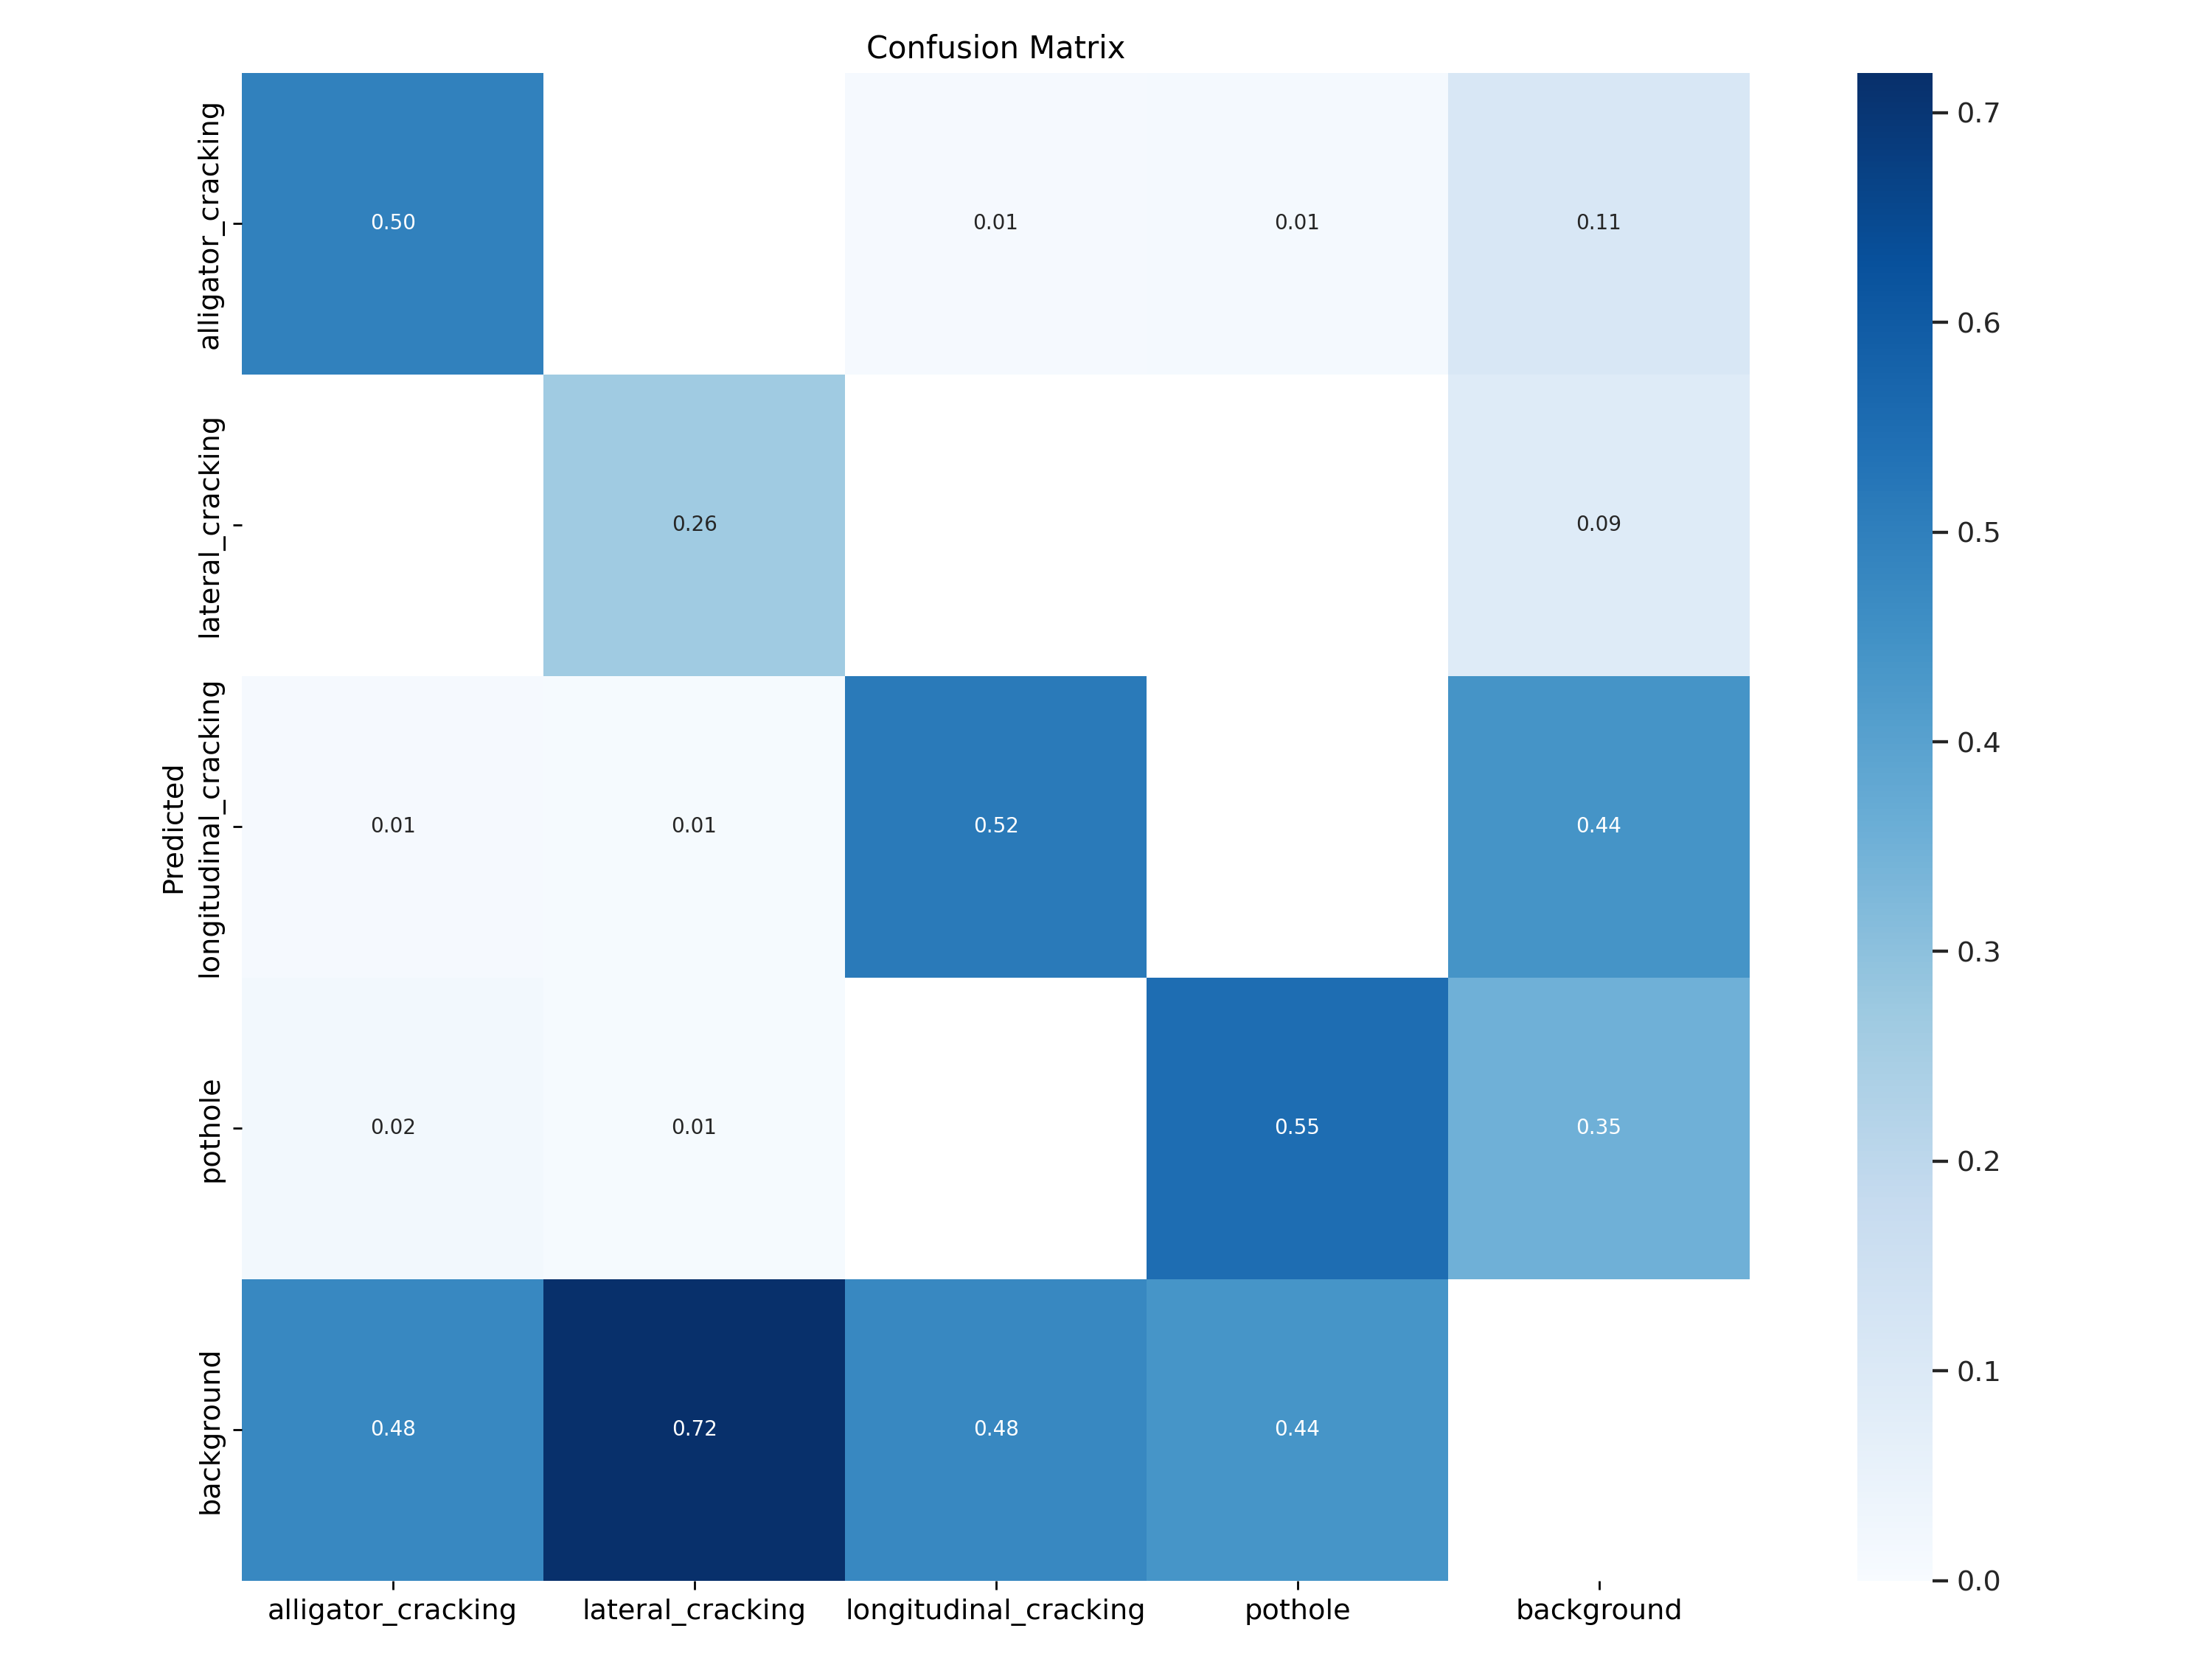

In [ ]:
from IPython.display import Image
Image(filename=f"{HOME}/yolov9/runs/val/exp2/confusion_matrix.png", width=1000)

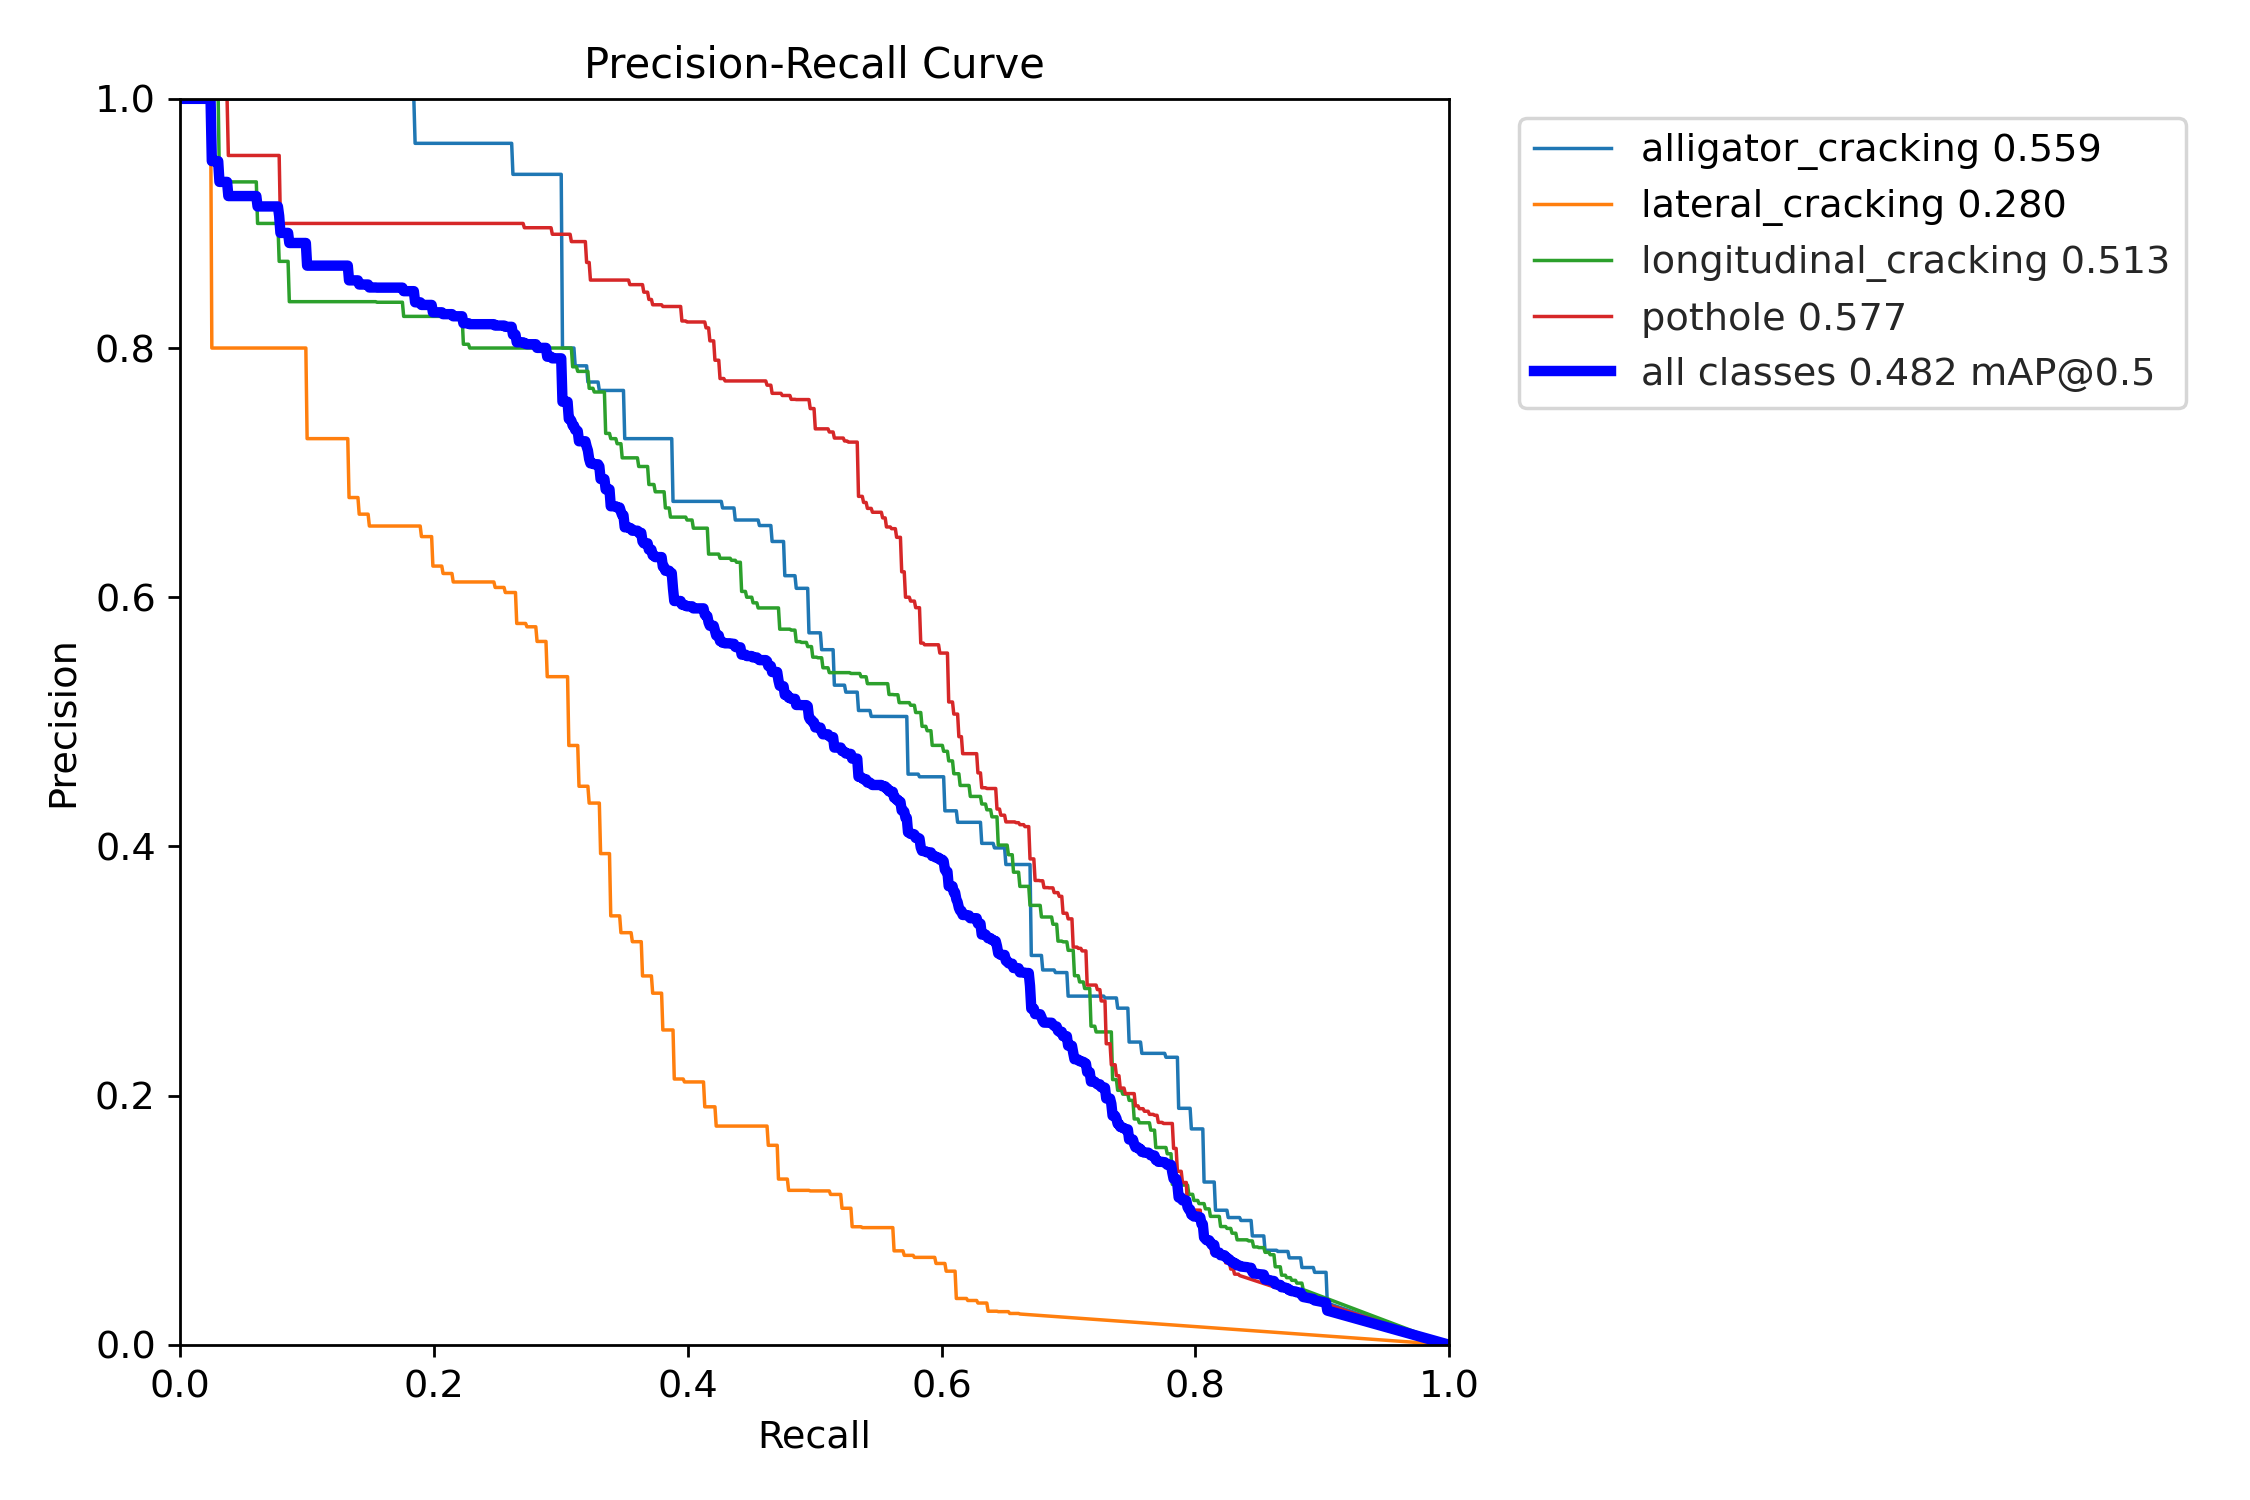

In [ ]:
from IPython.display import Image
Image(filename=f"{HOME}/yolov9/runs/val/exp2/PR_curve.png", width=1000)

# Inference

In [ ]:
!python detect.py \
--img 512 --conf 0.5 --device 0 \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt \
--source /content/yolov9/Deteksi-Kerusakan-Jalan-20/test/images

detect: weights=['/content/yolov9/runs/train/exp/weights/best.pt'], source=/content/yolov9/Deteksi-Kerusakan-Jalan-20/test/images, data=data/coco128.yaml, imgsz=[512, 512], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
gelan-c summary: 387 layers, 25230172 parameters, 0 gradients, 101.8 GFLOPs
image 1/331 /content/yolov9/Deteksi-Kerusakan-Jalan-20/test/images/AB_1020_jpeg.rf.60686c17f9794f0ce3f59a21c3b9a2fa.jpg: 288x512 1 longitudinal_cracking, 89.8ms
image 2/331 /content/yolov9/Deteksi-Kerusakan-Jalan-20/test/images/AB_12960_jpeg.rf.1e5219c42f672943f25700efab5e4e8a.jpg: 288x512 (n

In [ ]:
import glob

from IPython.display import Image, display

for image_path in glob.glob(f'/yolov9/runs/detect/exp/*.jpg')[:2]:
      display(Image(filename=image_path, width=600))

In [ ]:
!python detect.py \
--img 512 --conf 0.5 --device 0 \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt \
--source /content/drive/MyDrive/Tugas_Akhir/video/5_VID_20240418_102920.mp4

detect: weights=['/content/yolov9/runs/train/exp/weights/best.pt'], source=/content/drive/MyDrive/Tugas_Akhir/video/5_VID_20240418_102920.mp4, data=data/coco128.yaml, imgsz=[512, 512], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
gelan-c summary: 387 layers, 25230172 parameters, 0 gradients, 101.8 GFLOPs
video 1/1 (1/4803) /content/drive/MyDrive/Tugas_Akhir/video/5_VID_20240418_102920.mp4: 288x512 (no detections), 119.6ms
video 1/1 (2/4803) /content/drive/MyDrive/Tugas_Akhir/video/5_VID_20240418_102920.mp4: 288x512 (no detections), 24.4ms
video 1/1 (3/4803) /content/drive/MyDrive/

# Save to Drive

In [ ]:
from google.colab import drive
import os

In [ ]:
# Navigate to the folder
os.chdir('/content/yolov9/runs')

# Zip the folder
!zip -r yolov9-c_512_lr_0.0001.zip .

# Move the zip file to a different location in your Google Drive
!mv yolov9-c_512_lr_0.0001.zip '/content/drive/MyDrive/results_yolov9'

# Optional: List files in the destination directory to confirm
!ls '/content/drive/MyDrive/results_yolov9'

  adding: val/ (stored 0%)
  adding: val/exp2/ (stored 0%)
  adding: val/exp2/F1_curve.png (deflated 10%)
  adding: val/exp2/PR_curve.png (deflated 10%)
  adding: val/exp2/R_curve.png (deflated 9%)
  adding: val/exp2/confusion_matrix.png (deflated 24%)
  adding: val/exp2/P_curve.png (deflated 7%)
  adding: val/exp/ (stored 0%)
  adding: val/exp/F1_curve.png (deflated 10%)
  adding: val/exp/PR_curve.png (deflated 9%)
  adding: val/exp/R_curve.png (deflated 10%)
  adding: val/exp/confusion_matrix.png (deflated 23%)
  adding: val/exp/P_curve.png (deflated 8%)
  adding: train/ (stored 0%)
  adding: train/exp/ (stored 0%)
  adding: train/exp/labels.jpg (deflated 28%)
  adding: train/exp/weights/ (stored 0%)
  adding: train/exp/weights/best_striped.pt (deflated 8%)
  adding: train/exp/weights/last_striped.pt (deflated 8%)
  adding: train/exp/weights/best.pt (deflated 7%)
  adding: train/exp/weights/last.pt (deflated 7%)
  adding: train/exp/F1_curve.png (deflated 9%)
  adding: train/exp/label